# Case 2 - Diabetic Retinopathy
23.2.2018 (last modified)<br>
Tom Thiel<br>
Metropolia UAS<br>


Diabetic retinopathy (DR) is the leading cause of blindness in the working-age population of the developed world and is estimated to affect over 93 million people. The grading process consists of recognising very fine details, such as microaneurysms, to some bigger features, such as exudates, and sometimes their position relative to each other on images of the eye. 

https://www.kaggle.com/c/diabetic-retinopathy-detection

DR is a treatable condition when detected early enough. Development of the disease can be divided into 5 steps, from healthy (no DR) to proliferative DR. Problem is recogninsing these fine details to make clinical decisions. When showing the same picture from the data set to two Ophthalmologists, they can agree on the diagnose on 60 % of the time. What is more terrifying is that showing the same image to same Ophthalmologist few hours apart, they agree on the diagnose 65 % of the time. That's why the data set used in Kaggle is labeled in consesus of 7 Ophthalmologist. 

http://www.heidelberg-laureate-forum.org/blog/video/lecture-tuesday-september-26-2017-jeffrey-a-dean/ (~10min mark)


### Normal retina

<img src="img/normal-retina-180px.jpg" align="left">
<br>
<br>
<br>
<br>
<br>
<br>

### Diabetic Retina 
<img src="img/diabet-retina-180px.jpg" align="left">

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
https://www.aao.org/eye-health/diseases/what-is-diabetic-retinopathy

## 1. Objectives<br>

Objective of this assignemnt is to create model for finding showing signs of diabetic retinopathy from data set of fundus images. A deep convolutional neural network will be developed to classify healthy and the pathological ones. This is a binary classification task.

## 2. Import Libraries

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras import optimizers
import time

from sklearn.metrics import roc_curve, roc_auc_score

#importing VGG16 pre-trained model
from keras.applications import VGG16

Using TensorFlow backend.


In [6]:
#tried to insall CUDA and theano to run tensorflow-gpu, but couldn't get it to work.
#import theano 
#theano.config.device = 'gpu'
#theano.config.floatX = 'float32'  

#cheking the on witch device the script is running.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17367372874227976303
]


No GPU found, so TensorFlow runs the script on CPU. 8 logical cores @ 4.8 GHz should be sufficient for training the network in couple of hours, but a GPU setup would be preferable. 

For demostration a 90 sec video of comparative abilites of CPU and GPU in floating point calculation.
<a href="https://www.youtube.com/watch?v=-P28LKWTzrI" target="_blank">Demo GPU versus CPU</a>

## 3. Building library


In [7]:
#Using the weights from imagenet for initializing the weights
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

# Feeding the network all the images in size of 256x256 px and with dimension of 3 as red, green and blue.

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#show model layers and parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 23,103,809
Non-trainable params: 0
_________________________________________________________________


The network has total of 23M parameters.

In [8]:
print('number of trainable weights', len(model.trainable_weights))
conv_base.trainable = False
print('this is the number of trainable weights')
print('number of trainable weights', len(model.trainable_weights))

number of trainable weights 30
this is the number of trainable weights
number of trainable weights 4


In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4), #learning rate
              metrics=['acc'])

## 4. Data preprocessing

The data set was first split into training, validation and test subsets.

The images are then prosessed with imagedatagenerator. RGB coefficients are rescaled from 0-255 into values betwen 0 and 1. Rescaling makes the learning faster for the model. 


In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = "dataset2\\train"
validation_dir = "dataset2\\validation"
test_dir = "dataset2\\test"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.3, # zooming the images 30%
    horizontal_flip=True, 
    fill_mode='nearest')

validation_datagen = validation_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

#test data will not be manipulated. It's test as is.
test_datagen = ImageDataGenerator(rescale=1./255)

#training generator using the training data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

#validation generator for to se how the model is training
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')


model.save('case2combined.h5')

Found 1729 images belonging to 2 classes.
Found 749 images belonging to 2 classes.


1729 images for trainng.<br>
749 images for validation. 

In [11]:
#testing testing testing
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 256, 256, 3)
labels batch shape: (20,)


## 5. Modeling

In [12]:
#start timer to see how long the trainig takes.
tStart = time.time()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30, #
      verbose = 1, # show
      epochs=10,
      validation_data=validation_generator,
      validation_steps=5)

#stop the timer
tStop = time.time()
tElapsed = tStop - tStart
print('Time elapsed: {:.2f} sec'.format(tElapsed))

Epoch 1/10
30/30 [==============================] - 390s 13s/step - loss: 0.8031 - acc: 0.6217 - val_loss: 0.5340 - val_acc: 0.7200
Epoch 2/10
30/30 [==============================] - 362s 12s/step - loss: 0.5768 - acc: 0.7166 - val_loss: 0.5129 - val_acc: 0.7400
Epoch 3/10
30/30 [==============================] - 364s 12s/step - loss: 0.5920 - acc: 0.7050 - val_loss: 0.5728 - val_acc: 0.7000
Epoch 4/10
30/30 [==============================] - 371s 12s/step - loss: 0.5598 - acc: 0.7117 - val_loss: 0.5826 - val_acc: 0.7000
Epoch 5/10
30/30 [==============================] - 370s 12s/step - loss: 0.5465 - acc: 0.7250 - val_loss: 0.5049 - val_acc: 0.7100
Epoch 6/10
30/30 [==============================] - 364s 12s/step - loss: 0.5349 - acc: 0.7292 - val_loss: 0.4943 - val_acc: 0.7400
Epoch 7/10
30/30 [==============================] - 368s 12s/step - loss: 0.5371 - acc: 0.7217 - val_loss: 0.6357 - val_acc: 0.6800
Epoch 8/10
30/30 [==============================] - 360s 12s/step - loss: 0.

In [24]:
print('Elapset time {:.2f} hours.'.format((tStop-tStart)/3600)) 
print('Time perc epoch {:.2f} minutes.'.format((tStop-tStart)/300/60))
model.save('case2_run_4.h5') 

Elapset time 1.02 hours.
Time perc epoch 0.20 minutes.


Picture showing the CPU-usage of TensorFlow During the training.

<img src="img/cpu-usage.png" align="left">



## 6. Results


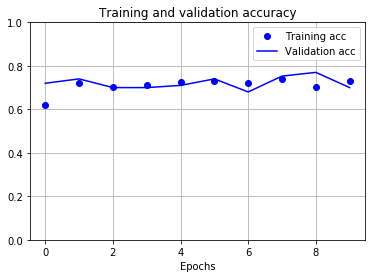

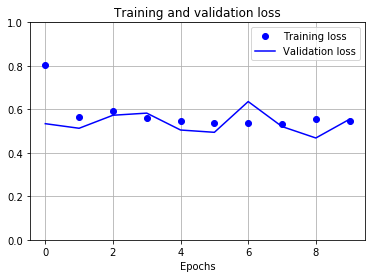

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.grid()
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 1])
plt.grid()
plt.xlabel('Epochs')
plt.legend()

plt.show()

Validation accuracy fluctuating between .7 - .77
Same goes with the validation loss it fluctuaes and doesn't have distinguishable direction. It doesn't get more accurate after the first epoch.
The ImageNet pre-trained weights seem to have alot higher level recognition already in them.

## 7. Test the model



In [15]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')

r = model.evaluate_generator(test_generator, steps=21)

#loss and accuracy
r

Found 735 images belonging to 2 classes.


[0.48897813118639444, 0.75238095011029926]

For the test set accuracy is 75 %.

## 8. Predict the score

In [16]:
#initialize values for the test set
y_true = np.zeros(735)
y_score = np.zeros(735)
sample_count = 735

i = 0
for inputs_batch, labels_batch in test_generator:
    predicts_batch = model.predict(inputs_batch)
    L = labels_batch.shape[0]
    index = range(i, i + L)
    y_true[index] = labels_batch.ravel()
    y_score[index] = predicts_batch.ravel()
    i = i + L
    if i >= sample_count:
        break

## 8.1 Calculate ROC and AUC

Sensitivity and specifity are expressions used in diagnosis. Positive in diagnosis means that the person is clinically recogninsed as diseased. Negative means that the person is healthy.

<b>Sensitivity</b> also called the true positive rate, the recall, or probability of detection, means how many of the diseased are found.

<b>Specificity</b> meaning measures the proportion of negatives that are correctly identified as such. 

<b>ROC</b> curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. ROC curve is created plotting the true positive rate (TPR, sensitivity) against the false positive rate (FPR, false alarm). 

<b>AUC</b> just means the Area Under the Curve.

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

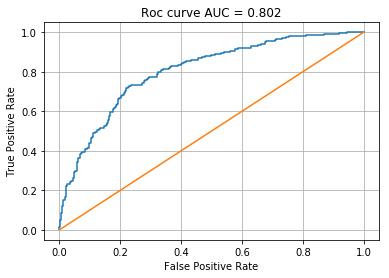

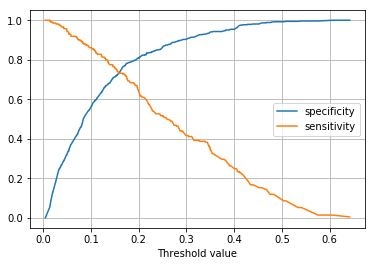

In [17]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

#plotting the ROC / AOC 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1]), [0, 1, '--']
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve AUC = {:.3f}'.format(auc))
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [18]:
#import the libraries for confusion matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [25]:
# select the threshold to maximize both specifity and sensitivity
th = 0.17
th

0.17

In [26]:
#bulding the confusion matrix
acc = accuracy_score(y_true, y_score > th)
prec = precision_score(y_true, y_score > th)
f1 = f1_score(y_true, y_score > th)
recall = recall_score(y_true, y_score > th)

#print('acc: {:,3f}'.format(acc))
#print('prec: {:, 3f}',format(prec))
#print('f1:   {:, 3f}',format(f1))
#print('recc: {:, 3f}'.format(recall))

In [27]:
print('classification report')
print(classification_report(y_true, y_score > th, labels = [1.0, 0.0], target_names = ['Disease', 'Healthy']))

classification report
             precision    recall  f1-score   support

    Disease       0.56      0.73      0.63       209
    Healthy       0.88      0.77      0.82       526

avg / total       0.79      0.76      0.77       735



Precision for finding the diseased is 56 %, which is almost the same as tossing a coin. 

The model finds the healthy samples with 88 % accuracy.

In [29]:
#Build the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_score > th).ravel()

print('                    Confusion matrix')
print()
print('                     Positive Negative      Sum')
print('Predicted | Positive {:8} {:8} {:8}'.format(tp, fp, tp + fp))
print('Condition | Negative {:8} {:8} {:8}'.format(fn, tn, fn + tn))
print('                 Sum {:8} {:8} {:8}'.format(tp + fn, fp + tn, tp + fp + fn + tn))
print()

print('sensitivity {:.3f}'.format(tp/(tp+fn)))
print('specificity {:.3f}'.format(tn/(tn+fp)))

                    Confusion matrix

                     Positive Negative      Sum
Predicted | Positive      152      121      273
Condition | Negative       57      405      462
                 Sum      209      526      735

sensitivity 0.727
specificity 0.770


## 9. Discussion

Looking the Kaggle competitions leaderboard reports, it seems that a major problem with clinical image recongisation data are the artefacts from cameras and lenses. And they are different in every laboraty. To ensure data quality carefull preprosessing steps should be taken reduce the showing of the artefacts.  

It quickly came apparent that I had no skills to preprocess the data correctly. So I just started to play with the network architecture. After trying few models own of my own and testing couple of models found on the Kaggle competition leaderboard documentary I draw to conclusion that the models were useless without well preprosessed data. Many of the competition entries also used 200 epochs and multiple sequential models. No time for that.

So I just went with the pre-trained VGG16-model on tensorflow. Used the imagenet weights and got results for 73 % sensitivity and 77 % specifity. As a binary classifier that is nothing to cheer for. 

<b>Automated detection lives up to the hype. </b> In the Journal of the American Medical Assosiation an article was published with validation of deep neural network system detecting vision-threatening diabetic retinopathy with 100% sensitivity and 91.1% specificity. That means that 100 % of the retinopathy cases were found and 91 % of the healthy individuals were diagnosed as healthy.

<img src="img/Untitled.jpg">



https://jamanetwork.com/journals/jama/article-abstract/2665775?redirect=true
